In [2]:
!pip install gym
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    100% |████████████████████████████████| 1.5MB 672kB/s 
    100% |████████████████████████████████| 1.0MB 1.1MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
Successfully built gym
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    14% |████▋                           | 85.4MB 58.1MB/s eta 0:00:09

    100% |████████████████████████████████| 592.3MB 49.9MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import argparse 
import gym
import numpy as np
import torch
from itertools import count
import matplotlib.pyplot as plt

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

In [5]:
env = gym.make('CartPole-v0')
env.seed(543)

gamma = 0.99
torch.manual_seed(543)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [0]:
class Policy(nn.Module):
  def __init__(self):
    super(Policy, self).__init__()
    self.layer1 = nn.Linear(4, 128)
    self.layer2 = nn.Linear(128, 2)
    
    self.saved_log_probs = []
    self.rewards = []
    
  def forward(self, x):
    x = F.relu(self.layer1(x))
    action_scores = self.layer2(x)
    return F.softmax(action_scores, dim=1)   #returns the probabilities after softmax 

  
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
  
  
def select_action(state):
  state = torch.from_numpy(state).float().unsqueeze(0)   #conver the numpy state to a torch tensor. #Unsqueeze returns a new tensor with a dimension of size one inserted at the specified position.
  probs = policy(Variable(state))   #Create tensors to hold state and outputs, and wrap them in Variables #Policy runs the forward function
  m = Categorical(probs)
  action = m.sample()
  policy.saved_log_probs.append(m.log_prob(action))
  return action.data[0]
  
  
def compute_returns_and_loss():
  G = 0
  policy_loss = []
  rewards = []
  for r in policy.rewards[::-1]:
    G = r + gamma * G
    rewards.insert(0, G)
    #print(rewards)
  G_per_episode = rewards[0]
  rewards = torch.Tensor(rewards)
  rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps) 
  for log_prob, reward in zip(policy.saved_log_probs, rewards):
    policy_loss.append(- log_prob * reward)
  optimizer.zero_grad()
  policy_loss = torch.cat(policy_loss).sum()
  optimizer.step()
  del policy.rewards[:]
  del policy.saved_log_probs[:]
  return G_per_episode

In [0]:
def main():
  sum_reward = 0
  G_episode_wise = []
  sum_reward_running_episodes = []
  for episode in count(1):
    state = env.reset()
    sum_reward_running = 0
    for timestep in range(200):
      action = select_action(state)
      state, reward, done, _ = env.step(action)
      sum_reward +=  reward
      if flagtorender == 'true':
        env.render()
      policy.rewards.append(reward) #Generate an episode So, Ao, R1, S1, A1, R2......
      if done:
        break
          
    G_current_episode = compute_returns_and_loss()
    G_episode_wise.append(G_current_episode)    
    sum_reward_running = sum_reward_running * 0.95 + sum_reward * 0.05
    sum_reward_running_episodes.append(sum_reward_running)
    
    plt.plot(range(episode), sum_reward_running_episodes, linewidth=3)
    if sum_reward_running > reward_threshold:
      print('%d running reward: %f' % (episode, sum_reward_running))
      break
  
  
  plt.xlabel("Episodes", fontsize=14)
  plt.ylabel("Total Reward for Each Episode", fontsize=14)
  plt.title("REINFORCE on Cartpole - Returns vs episode", fontsize=14)
  plt.show()
    

195 running reward: 201.500000


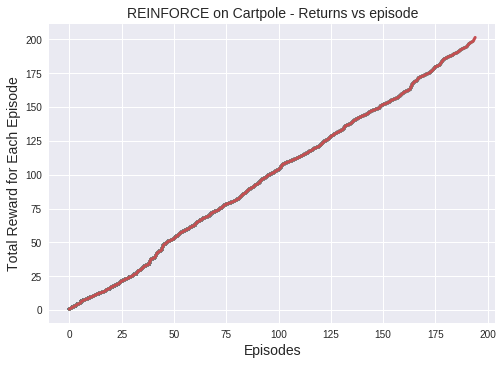

In [27]:
flagtorender = 'false'
reward_threshold = 200
main()